In [38]:
'''!pip uninstall -y numpy gensim
!pip install numpy==1.23.5  
!pip install gensim         

# Also install TensorFlow for later use
!pip install tensorflow==2.19.0  

# Force restart the kernel after installing packages
print("Please restart the kernel after running this cell.")'''

'!pip uninstall -y numpy gensim\n!pip install numpy==1.23.5  \n!pip install gensim         \n\n# Also install TensorFlow for later use\n!pip install tensorflow==2.19.0  \n\n# Force restart the kernel after installing packages\nprint("Please restart the kernel after running this cell.")'

# Semantic Text Similarity
Este modelo utiliza gensim para convertir pares de vectores + puntuacions en vectores (word embeddings).
Dado un dataset, infere la puntuació de similitud entre ambdues frases.

In [39]:
import os
# Requisits
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import numpy as np

In [40]:
# Tipat
from typing import Tuple, List, Optional

In [41]:
# Models pre-entrenats
# WV_MODEL_PATH = "/Users/salva/Downloads/cc.ca.300.bin.gz"


'''WV_MODEL_PATH = '/Users/salva/Downloads/cc.ca.300.vec.gz'
import gensim
wv_model =  gensim.models.KeyedVectors.load_word2vec_format(WV_MODEL_PATH, binary=False)
wv_model'''

"WV_MODEL_PATH = '/Users/salva/Downloads/cc.ca.300.vec.gz'\nimport gensim\nwv_model =  gensim.models.KeyedVectors.load_word2vec_format(WV_MODEL_PATH, binary=False)\nwv_model"

In [42]:
# Llavors podeu carregar el model com a mmap
from gensim.models.fasttext import FastTextKeyedVectors
wv_model = FastTextKeyedVectors.load('../cc.ca.gensim.bin', mmap='r')

In [43]:
# Exemple de 10 parells d'oracions amb puntuació de similitud associada
input_pairs = [
    ('M\'agrada el futbol', 'Disfruto veient partits de futbol', 4),
    ('El cel està despejat', 'Fa un dia bonic', 4.5),
    ('M\'encanta viatjar', 'Explorar nous llocs és una passió', 3.5),
    ('Prefereixo l\'estiu', 'No m\'agrada el fred de l\'hivern', 2.5),
    ('Tinc gana', 'Què hi ha per sopar?', 2),
    ('La música em relaxa', 'Escoltar música és una teràpia', 3),
    ('El llibre és emocionant', 'No puc deixar de llegir-lo', 4),
    ('M\'agrada la pizza', 'És el meu menjar preferit', 4.5),
    ('Estic cansat', 'Necessito fer una migdiada', 1.5),
    ('Avui fa molta calor', 'És un dia sofocant', 3.5)
    ]

In [44]:
REMAP_EMBEDDINGS: bool = True
USE_PRETRAINED: bool = True

In [45]:
from datasets import load_dataset
# Text Similarity (STS) dataset (principal per la Pràctica 4)
train = load_dataset("projecte-aina/sts-ca", split="train")
test = load_dataset("projecte-aina/sts-ca", split="test")
val = load_dataset("projecte-aina/sts-ca", split="validation")

all_data = load_dataset("projecte-aina/sts-ca", split="all")
print(f"Train: {len(train)} samples, Validation: {len(val)} samples, Test: {len(test)} samples")
all_data

Train: 2073 samples, Validation: 500 samples, Test: 500 samples


Dataset({
    features: ['id', 'sentence_1', 'sentence_2', 'label'],
    num_rows: 3073
})

In [46]:
def map_corpus(corpus):
    """
    Preprocesses a dataset corpus by extracting sentence pairs and their similarity scores.
    
    Args:
        corpus: A dataset containing 'sentence_1', 'sentence_2', and 'label' fields
        
    Returns:
        List of tuples containing (preprocessed_sentence_1, preprocessed_sentence_2, score)
    """
    sentences_1_preproc = [simple_preprocess(d["sentence_1"]) for d in corpus] #lista de listas que son oraciones lematizadas
    sentences_2_preproc = [simple_preprocess(d["sentence_2"]) for d in corpus]
    scores = [d["label"] for d in corpus]
    sentence_pairs = list(zip(sentences_1_preproc, sentences_2_preproc, scores))
    return sentences_1_preproc, sentences_2_preproc, scores, sentence_pairs

# Process each dataset
sentences_1_preproc, sentences_2_preproc, scores, sentence_pairs = map_corpus(all_data)

# Optionally process train/test/val sets separately
train_s1, train_s2, train_scores, train_pairs = map_corpus(train)
test_s1, test_s2, test_scores, test_pairs = map_corpus(test)
val_s1, val_s2, val_scores, val_pairs = map_corpus(val)

In [47]:
# Versió aplanada per poder entrenar el model
sentences_pairs_flattened = sentences_1_preproc + sentences_2_preproc
diccionario = Dictionary(sentences_pairs_flattened)
diccionario

## Alternative Baseline : One-Hot Encoding

Una altra alternativa és utilitzar One-Hot Encoding per representar les frases. Això pot ser útil per comparar la similitud entre frases de manera més directa, encara que no captura la semàntica de les paraules com ho fan els word embeddings. La similitud es pot calcular fent servir la distància de Jaccard (número de paraules en comú dividit entre número de paraules totals entre les dues frases) o el coseno entre els vectors resultants.

In [48]:
# Usant la distància Jaccard per avaluar la similitud entre oracions
from typing import List, Set, Union
import numpy as np

def one_hot_evaluation(sent1: List[Union[str, Set[str]]], sent2: List[Union[str, Set[str]]]) -> float:
    """
    Calcular la similitud de Jaccard entre dues oracions
    
    Args:
        sent1: Primera oració tokenitzada com una llista de paraules o conjunts de paraules
        sent2: Segona oració tokenitzada com una llista de paraules o conjunts de paraules
        
    Returns:
        float: Puntuació de similitud basada en la distància de Jaccard
    """
    scores = []
    for i in range(len(sent1)):
        # Convertir a conjunts si no ho són ja
        set1 = set(sent1[i]) if not isinstance(sent1[i], set) else sent1[i]
        set2 = set(sent2[i]) if not isinstance(sent2[i], set) else sent2[i]
        
        # Calcular la similitud de Jaccard
        score = len(set1.intersection(set2)) / len(set1.union(set2))
        scores.append(score)
    
    # Retornar la puntuació mitjana si tenim puntuacions vàlides
    return scores

In [49]:
# Usando la distancia coseno para calcular la similitud entre dos oraciones
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import numpy as np

def one_hot_cosine_similarity(sent1: List[Union[str, Set[str]]], sent2: List[Union[str, Set[str]]], vocabulary: Optional[Dictionary] = None) -> List[float]:
    """
    Calcula la similitud del coseno entre pares de oracions utilizando representación one-hot encoding
    
    Args:
        sent1: Lista de oraciones tokenizadas (primera oración de cada par)
        sent2: Lista de oraciones tokenizadas (segona oración de cada par)
        vocabulary: Diccionario opcional para mapear palabras a índices
        
    Returns:
        List[float]: Lista de puntuaciones de similitud basadas en el coseno
    """
    scores = []
    
    for i in range(len(sent1)):
        # Convertir a conjuntos para facilitar el manejo
        set1 = set(sent1[i]) if not isinstance(sent1[i], set) else sent1[i]
        set2 = set(sent2[i]) if not isinstance(sent2[i], set) else sent2[i]
        
        if vocabulary:
            # Usar el vocabulario proporcionado
            vocab_size = len(vocabulary.token2id)
            vec1 = np.zeros(vocab_size)
            vec2 = np.zeros(vocab_size)
            
            for word in set1:
                if word in vocabulary.token2id:
                    vec1[vocabulary.token2id[word]] = 1
                    
            for word in set2:
                if word in vocabulary.token2id:
                    vec2[vocabulary.token2id[word]] = 1
        else:
            # Crear un vocabulario ad-hoc para este par
            all_words = set1.union(set2)
            word_to_idx = {word: idx for idx, word in enumerate(all_words)}
            
            vec1 = np.zeros(len(all_words))
            vec2 = np.zeros(len(all_words))
            
            for word in set1:
                vec1[word_to_idx[word]] = 1
                
            for word in set2:
                vec2[word_to_idx[word]] = 1
        
        # Calcular similitud del coseno
        # Si los vectores son cero, asignamos una similitud de 0
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        
        if norm1 == 0 or norm2 == 0:
            scores.append(0.0)
        else:
            cos_sim = np.dot(vec1, vec2) / (norm1 * norm2)
            scores.append(cos_sim)
    
    return scores

# Ejemplo de uso
# similitudes = one_hot_cosine_similarity(sentences_1_preproc[:5], sentences_2_preproc[:5], diccionario)
# print(similitudes)

## Modelo regressió amb atenció



In [50]:
print("Max Len:", max([len(s) for s in sentences_1_preproc]), max([len(s) for s in sentences_2_preproc]))
print(list(diccionario.doc2idx(sentences_1_preproc[0])))

Max Len: 30 30
[0, 11, 13, 1, 9, 10, 5, 14, 8, 7, 2, 8, 12, 2, 6, 4, 3, 15]


In [51]:
from typing import Union


def map_word_embeddings(
        sentence: Union[str, List[str]],
        sequence_len: int = 32,
        fixed_dictionary: Optional[Dictionary] = None
        ) -> np.ndarray:
    """
    Map to word-embedding indices
    :param sentence:
    :param sequence_len:
    :param fixed_dictionary:
    :return:
    """
    if not isinstance(sentence, list):
        sentence_preproc = simple_preprocess(sentence)
    else:
        sentence_preproc = sentence
    _vectors = np.zeros(sequence_len, dtype=np.int32)
    index = 0
    for word in sentence_preproc:
        if fixed_dictionary is not None:
            if word in fixed_dictionary.token2id:
                # Sumo 1 perquè el valor 0 està reservat a padding
                _vectors[index] = fixed_dictionary.token2id[word] + 1
                index += 1
        else:
            if word in wv_model.key_to_index:
                _vectors[index] = wv_model.key_to_index[word] + 1
                index += 1
    return _vectors


def map_pairs(
        sentence_pairs: List[Tuple[str, str, float]],
        sequence_len: int = 32,
        fixed_dictionary: Optional[Dictionary] = None
) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    """
    Mapea els triplets d'oracions a llistes de (x, y), (pares de vectors, score)
    :param sentence_pairs:
    :param sequence_len:
    :param fixed_dictionary:
    :return:
    """
    # Mapeig dels paquets d'oracions a paquets de vectors
    pares_vectores = []
    for i, (sentence_1, sentence_2, similitud) in enumerate(sentence_pairs):
        vector1 = map_word_embeddings(sentence_1, sequence_len, fixed_dictionary)
        vector2 = map_word_embeddings(sentence_2, sequence_len, fixed_dictionary)
        # Afegir a la llista
        pares_vectores.append(((vector1, vector2), similitud))
    return pares_vectores

In [52]:
# Imprimir els paquets de vectors i la puntuació de similitud associada
mapped = map_pairs(sentence_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None)
# for vectors, similitud in mapped:
#     print(f"Pares de vectores: {vectors[0].shape}, {vectors[1].shape}")
#     print(f"Puntuació de similitud: {similitud}")
print(mapped[0])

((array([ 1, 12, 14,  2, 10, 11,  6, 15,  9,  8,  3,  9, 13,  3,  7,  5,  4,
       16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([10010,     9,  2784,     6,    15,     9,     8,     3,     9,
          13,     3,     7,     5,     4,    16,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])), 3.5)


In [53]:
# Definir constants d'entrenament
batch_size: int = 64
num_epochs: int = 128
# train_val_split variable is no longer needed since we're using the predefined splits

In [54]:
len(mapped)

3073

In [55]:
# Process each dataset separately
# Map train, val, and test sets to word embeddings
train_mapped = map_pairs(train_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None)
val_mapped = map_pairs(val_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None)
test_mapped = map_pairs(test_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None)

def pair_list_to_x_y(pair_list: List[Tuple[Tuple[np.ndarray, np.ndarray], int]]) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
    """
    Otiene las matrices X_1 (N x d) , X_2 (N x d), e Y (n) a partir de listas de parelles de vectors d'oracions - Llistes de (d, d, 1)
    :param pair_list:
    :return:
    """
    _x, _y = zip(*pair_list)
    _x_1, _x_2 = zip(*_x)
    return (np.row_stack(_x_1), np.row_stack(_x_2)), np.array(_y) / 5.0

# Obtener las listas de train, val i test
x_train, y_train = pair_list_to_x_y(train_mapped)
x_val, y_val = pair_list_to_x_y(val_mapped)
x_test, y_test = pair_list_to_x_y(test_mapped)

print(f"Train shapes: {x_train[0].shape}, {x_train[1].shape}, {y_train.shape}")
print(f"Validation shapes: {x_val[0].shape}, {x_val[1].shape}, {y_val.shape}")
print(f"Test shapes: {x_test[0].shape}, {x_test[1].shape}, {y_test.shape}")

Train shapes: (2073, 32), (2073, 32), (2073,)
Validation shapes: (500, 32), (500, 32), (500,)
Test shapes: (500, 32), (500, 32), (500,)


In [56]:
import tensorflow as tf

# Preparar els conjunts de dades d'entrenament, validació i test
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train[0])).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

print(f"Batches in train_dataset: {len(list(train_dataset))}")
print(f"Batches in val_dataset: {len(list(val_dataset))}")
print(f"Batches in test_dataset: {len(list(test_dataset))}")

Batches in train_dataset: 33
Batches in val_dataset: 8
Batches in test_dataset: 8


In [57]:
import tensorflow as tf
print(tf.__version__)
print(dir(tf))  # ¿"data" aparece en esta lista?


2.19.0
['AggregationMethod', 'Assert', 'CriticalSection', 'DType', 'DeviceSpec', 'GradientTape', 'Graph', 'IndexedSlices', 'IndexedSlicesSpec', 'Module', 'Operation', 'OptionalSpec', 'RaggedTensor', 'RaggedTensorSpec', 'RegisterGradient', 'SparseTensor', 'SparseTensorSpec', 'Tensor', 'TensorArray', 'TensorArraySpec', 'TensorShape', 'TensorSpec', 'TypeSpec', 'UnconnectedGradients', 'Variable', 'VariableAggregation', 'VariableSynchronization', '_API_MODULE', '_KerasLazyLoader', '__all__', '__builtins__', '__cached__', '__compiler_version__', '__cxx11_abi_flag__', '__cxx_version__', '__doc__', '__file__', '__git_version__', '__internal__', '__loader__', '__monolithic_build__', '__name__', '__operators__', '__package__', '__path__', '__spec__', '__version__', '_api', '_compat', '_current_file_location', '_current_module', '_fi', '_initializers', '_inspect', '_kernel_dir', '_ll', '_losses', '_major_api_version', '_metrics', '_module_dir', '_module_util', '_name', '_names_with_underscore', '

In [58]:
pretrained_weights: Optional[np.ndarray] = None
if USE_PRETRAINED:
    if REMAP_EMBEDDINGS:
        pretrained_weights = np.zeros(
            (len(diccionario.token2id) + 1, wv_model.vector_size),  dtype=np.float32)
        for token, _id in diccionario.token2id.items():
            if token in wv_model:
                pretrained_weights[_id + 1] = wv_model[token]
            else:
                # In W2V, OOV will not have a representation. We will use 0.
                pass
    else:
        # Not recommended (this will consume A LOT of RAM) PORQUE CARGA TODOS LOS VECTORES DEL MODELO.
        pretrained_weights = np.zeros((wv_model.vectors.shape[0] + 1, wv_model.vector_size,),  dtype=np.float32)
        pretrained_weights[1:, :] = wv_model.vectors


In [59]:
pretrained_weights[:5]

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [-0.0307,  0.0032,  0.0128, ..., -0.0154,  0.0374,  0.0234],
       [ 0.0519, -0.0079, -0.0013, ..., -0.0154, -0.0353, -0.0235],
       [ 0.0058, -0.0161,  0.062 , ...,  0.0129,  0.019 ,  0.0177],
       [-0.042 , -0.0113,  0.0837, ..., -0.0396, -0.0253, -0.0045]],
      dtype=float32)

In [60]:
import tensorflow as tf
import numpy as np
from typing import Optional

class SimpleAttention(tf.keras.layers.Layer):
    def __init__(self, units: int, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.units = units
        self.dropout_s1 = tf.keras.layers.Dropout(0.3)
        self.dropout_s2 = tf.keras.layers.Dropout(0.2)
        self.W_s1 = tf.keras.layers.Dense(units, activation='tanh', use_bias=True, name="attention_transform")
        # Dense layer to compute attention scores (context vector)
        self.W_s2 = tf.keras.layers.Dense(1, use_bias=False, name="attention_scorer")
        self.supports_masking = True  # Declare that this layer supports masking

    def call(self, inputs: tf.Tensor, mask: Optional[tf.Tensor] = None) -> tf.Tensor:
        # inputs shape: (batch_size, sequence_length, embedding_dim)
        # mask shape: (batch_size, sequence_length) boolean tensor

        # Attention hidden states
        hidden_states = self.dropout_s1(self.W_s1(inputs))

        # Compute attention scores
        scores = self.dropout_s2(self.W_s2(hidden_states))

        if mask is not None:
            # Apply the mask to the scores before softmax
            expanded_mask = tf.expand_dims(tf.cast(mask, dtype=tf.float32), axis=-1)
            # Add a large negative number to masked (padded) scores
            scores += (1.0 - expanded_mask) * -1e9

        # Compute attention weights
        attention_weights = tf.nn.softmax(scores, axis=1)

        # Compute the context vector (weighted sum of input embeddings)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        return context_vector

    def get_config(self) -> dict:
        config = super(SimpleAttention, self).get_config()
        config.update({"units": self.units})
        return config

    def compute_mask(self, inputs: tf.Tensor, mask: Optional[tf.Tensor] = None) -> Optional[tf.Tensor]:
        return None


def build_and_compile_model_2(
        input_length: int = 32,
        dictionary_size: int = 1000,
        embedding_size: int = 300,
        learning_rate: float = 0.001,
        trainable_embedding: bool = False,
        pretrained_weights: Optional[np.ndarray] = None,
        attention_units: int = 4,
) -> tf.keras.Model:
    input_1 = tf.keras.Input((input_length,), dtype=tf.int32, name="input_1")
    input_2 = tf.keras.Input((input_length,), dtype=tf.int32, name="input_2")

    # Determine effective embedding parameters
    if pretrained_weights is not None:
        effective_dictionary_size = pretrained_weights.shape[0]
        effective_embedding_size = pretrained_weights.shape[1]
        embedding_initializer = tf.keras.initializers.Constant(pretrained_weights)
        is_embedding_trainable = trainable_embedding
        embedding_layer_name = "embedding_pretrained"
    else:
        effective_dictionary_size = dictionary_size
        effective_embedding_size = embedding_size
        embedding_initializer = 'uniform'
        is_embedding_trainable = True
        embedding_layer_name = "embedding"

    # Shared Embedding Layer
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=effective_dictionary_size,
        output_dim=effective_embedding_size,
        input_length=input_length,
        mask_zero=True,
        embeddings_initializer=embedding_initializer,
        trainable=is_embedding_trainable,
        name=embedding_layer_name
    )

    # Apply embedding layer to both inputs
    embedded_1 = embedding_layer(input_1)  # Shape: (batch_size, input_length, effective_embedding_size)
    embedded_2 = embedding_layer(input_2)  # Shape: (batch_size, input_length, effective_embedding_size)

    # Shared Attention Layer
    # Input: (batch_size, input_length, effective_embedding_size) with a mask
    # Output: (batch_size, effective_embedding_size)
    sentence_attention_layer = SimpleAttention(units=attention_units, name="sentence_attention")
    # sentence_attention_layer = tf.keras.layers.GlobalAveragePooling1D(name="sentence_attention_layer")

    sentence_vector_1 = sentence_attention_layer(embedded_1)
    sentence_vector_2 = sentence_attention_layer(embedded_2)

    # Projection layer
    first_projection_layer = tf.keras.layers.Dense(
        effective_embedding_size,
        activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
        name="projection_layer"
    )
    dropout = tf.keras.layers.Dropout(0.2, name="projection_dropout")
    projected_1 = dropout(first_projection_layer(sentence_vector_1))
    projected_2 = dropout(first_projection_layer(sentence_vector_2))

    # Normalize the projected vectors (L2 normalization)
    normalized_1 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_1"
    )(projected_1)
    normalized_2 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_2"
    )(projected_2)

    # Compute Cosine Similarity = X * Y / (||X|| * ||Y||) 
    similarity_score = tf.keras.layers.Lambda(
        lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True), name="cosine_similarity"
    )([normalized_1, normalized_2])

    # Scale similarity from [-1, 1] to [0, 1]
    output_layer = tf.keras.layers.Lambda(
        lambda x: 0.5 * (1.0 + x), name="output_scaling"
    )(similarity_score)

    # Define the Keras Model
    model = tf.keras.Model(
        inputs=[input_1, input_2],
        outputs=output_layer,
        name="sequence_similarity_attention_model"
    )

    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae'],
    )

    return model

In [61]:
# Construir i compilar el model
model = build_and_compile_model_2(pretrained_weights=pretrained_weights, learning_rate=1e-3)
# Entrenar el model
model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

c:\Users\jiahu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1273 - mae: 0.3187 - val_loss: 0.1514 - val_mae: 0.3556
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1273 - mae: 0.3187 - val_loss: 0.1514 - val_mae: 0.3556
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0828 - mae: 0.2488 - val_loss: 0.1408 - val_mae: 0.3429
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0828 - mae: 0.2488 - val_loss: 0.1408 - val_mae: 0.3429
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0654 - mae: 0.2159 - val_loss: 0.1345 - val_mae: 0.3357
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0654 - mae: 0.2159 - val_loss: 0.1345 - val_mae: 0.3357
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0621 - mae: 0.2078 - val_loss: 0.1314 - val_mae: 0.3323
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0621 - mae: 0.2078 - val_loss: 0.1314 - val_mae: 0.3323
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - lo

In [62]:
model.summary()

Model: "sequence_similarity_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_pretrain… │ (None, 32, 300)   │  3,937,800 │ input_1[0][0],    │
│ (Embedding)         │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_12        │ (None, 32)        │          0 │ input_1[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_13        │ (None, 32)        │          0 │ input_2[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentence_attention  │ (None, 300)       │      1,208 │ embedding_pretra… │
│ (SimpleAttention)   │                   │            │ not_equal_12[0][… │
│                     │                   │            │ embedding_pretra… │
│                     │                   │            │ not_equal_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ projection_layer    │ (None, 300)       │     90,300 │ sentence_attenti… │
│ (Dense)             │                   │            │ sentence_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ projection_dropout  │ (None, 300)       │          0 │ projection_layer… │
│ (Dropout)           │                   │            │ projection_layer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_1         │ (None, 300)       │          0 │ projection_dropo… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_2         │ (None, 300)       │          0 │ projection_dropo… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cosine_similarity   │ (None, 1)         │          0 │ normalize_1[0][0… │
│ (Lambda)            │                   │            │ normalize_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_scaling      │ (None, 1)         │          0 │ cosine_similarit… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,212,326 (16.07 MB)

 Trainable params: 91,508 (357.45 KB)

 Non-trainable params: 3,937,800 (15.02 MB)

 Optimizer params: 183,018 (714.92 KB)

In [63]:
from scipy.stats import pearsonr
# Obtener las predicciones del modelo para los datos de prueba. En este ejemplo vamos a utilizar el corpus de training.
y_pred = model.predict(x_val)
# Calcular la correlación de Pearson entre las predicciones y los datos de prueba
correlation, _ = pearsonr(y_pred.flatten(), y_val.flatten())
# Imprimir el coeficiente de correlación de Pearson
print(f"Correlación de Pearson: {correlation}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Correlación de Pearson: 0.4770294564982235
Correlación de Pearson: 0.4770294564982235


In [64]:
from scipy.stats import pearsonr
# Obtener las predicciones del modelo para los datos de prueba. En este exemple vamos a utilizar el corpus de training.
y_pred = model.predict(x_train)
# Calcular la correlación de Pearson entre las predicciones i els dades de prova
correlation, _ = pearsonr(y_pred.flatten(), y_train.flatten())
# Imprimir el coeficiente de correlación de Pearson
print(f"Correlación de Pearson: {correlation}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Correlación de Pearson: 0.7141764493478945
Correlación de Pearson: 0.7141764493478945


In [65]:
tf.__version__

'2.19.0'

In [66]:
print(y_train[:10])

[0.7   0.25  0.734 0.45  0.4   0.55  0.534 0.5   0.5   0.6  ]


In [67]:
# Calculate Jaccard similarity for the train dataset
train_jaccard_scores = one_hot_evaluation(train_s1, train_s2)

# Convert to numpy array for proper comparison
train_jaccard_scores = np.array(train_jaccard_scores)

print(f"Length of Jaccard scores: {len(train_jaccard_scores)}, Length of y_train: {len(y_train)}")

# Now both arrays should have the same length
correlation, p_value = pearsonr(train_jaccard_scores, y_train.flatten())
print(f"Train Jaccard Correlation de Pearson: {correlation}")

# Also calculate for validation
val_jaccard_scores = one_hot_evaluation(val_s1, val_s2)
val_jaccard_scores = np.array(val_jaccard_scores)
val_correlation, val_p_value = pearsonr(val_jaccard_scores, y_val.flatten())
print(f"Validation Jaccard Correlation de Pearson: {val_correlation}")

Length of Jaccard scores: 2073, Length of y_train: 2073
Train Jaccard Correlation de Pearson: 0.5417092707292863
Validation Jaccard Correlation de Pearson: 0.5002332577241272


In [68]:
# Calculate cosine similarity for the train dataset
train_cosine_scores = one_hot_cosine_similarity(train_s1, train_s2)

# Convert to numpy array for proper comparison
train_cosine_scores = np.array(train_cosine_scores)

print(f"Length of Cosine scores: {len(train_cosine_scores)}, Length of y_train: {len(y_train)}")

# Now both arrays should have the same length
correlation, p_value = pearsonr(train_cosine_scores, y_train.flatten())
print(f"Train Cosine Correlation de Pearson: {correlation}")

# Also calculate for validation with the same method (cosine similarity)
val_cosine_scores = one_hot_cosine_similarity(val_s1, val_s2)
val_cosine_scores = np.array(val_cosine_scores)
val_correlation, val_p_value = pearsonr(val_cosine_scores, y_val.flatten())
print(f"Validation Cosine Correlation de Pearson: {val_correlation}")


Length of Cosine scores: 2073, Length of y_train: 2073
Train Cosine Correlation de Pearson: 0.5519919131699983
Validation Cosine Correlation de Pearson: 0.5074905114012317

Train Cosine Correlation de Pearson: 0.5519919131699983
Validation Cosine Correlation de Pearson: 0.5074905114012317


#### TODO

- Model difícil de millorar
- Truncar les mesures dels embeddings extreient les paraules que pertanyen al corpus (cuidado amb overfitting al train).
- Agregació amb altres TF-IDF. (Modificant la capa Atenció)
- 

## Experimentació amb diferents dimensions de embeddings

Per estudiar com varia la capacitat del model segons la mida dels word embeddings, crearem versions reduïdes dels embeddings amb diferents dimensions (50, 100, 150) i compararem el seu rendiment.

In [69]:
# Crear versions reduïdes de los word embeddings
import time
from collections import defaultdict

# Función para crear embeddings de dimensión reducida
def create_reduced_embeddings(original_model, dimensions=[50, 100, 150]):
    """
    Crea versiones reducidas de los word embeddings originales.
    
    Args:
        original_model: Modelo de word embeddings original
        dimensions: Lista de dimensiones a las que reducir los embeddings
        
    Returns:
        dict: Diccionario con los modelos reducidos (key: dimensión, value: modelo)
    """
    reduced_models = {}
    
    print(f"Creando versiones reducidas de los embeddings ({len(original_model.index_to_key)} palabras)...")
    start_time = time.time()
    
    for dim in dimensions:
        print(f"Creando modelo de {dim} dimensiones...")
        # Utilizamos defaultdict para evitar KeyError cuando busquemos palabras
        reduced_model = defaultdict(lambda: np.zeros(dim))
        
        # Solo procesamos las primeras 'dim' dimensiones de cada vector
        for word in original_model.index_to_key:
            reduced_model[word] = original_model[word][:dim]
        
        reduced_models[dim] = reduced_model
        print(f"Modelo de {dim}d creado. Ejemplo: 'casa' tiene forma {reduced_model['casa'].shape}")
    
    elapsed_time = time.time() - start_time
    print(f"Tiempo total para crear modelos reducidos: {elapsed_time:.2f} segundos")
    
    return reduced_models

# Crear modelos con dimensiones reducidas
reduced_models = create_reduced_embeddings(wv_model)

# Verificar algunos vectores para confirmar que la reducción funciona
for dim in reduced_models:
    print(f"\nDimensión {dim}:")
    test_word = "casa" if "casa" in wv_model else wv_model.index_to_key[0]
    print(f"Palabra '{test_word}' - Vector: {reduced_models[dim][test_word][:5]}... (forma: {reduced_models[dim][test_word].shape})")

Creando versiones reducidas de los embeddings (2000000 palabras)...
Creando modelo de 50 dimensiones...
Modelo de 50d creado. Ejemplo: 'casa' tiene forma (50,)
Creando modelo de 100 dimensiones...
Modelo de 50d creado. Ejemplo: 'casa' tiene forma (50,)
Creando modelo de 100 dimensiones...
Modelo de 100d creado. Ejemplo: 'casa' tiene forma (100,)
Creando modelo de 150 dimensiones...
Modelo de 100d creado. Ejemplo: 'casa' tiene forma (100,)
Creando modelo de 150 dimensiones...
Modelo de 150d creado. Ejemplo: 'casa' tiene forma (150,)
Tiempo total para crear modelos reducidos: 125.02 segundos

Dimensión 50:
Palabra 'casa' - Vector: [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (forma: (50,))

Dimensión 100:
Palabra 'casa' - Vector: [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (forma: (100,))

Dimensión 150:
Palabra 'casa' - Vector: [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (forma: (150,))
Modelo de 150d creado. Ejemplo: 'casa' tiene forma (150,)
Tiempo total para crear modelos reducidos

In [70]:
# Función para generar los pesos pre-entrenados con dimensiones reducidas
def generate_pretrained_weights(dimension, dictionary=diccionario):
    """
    Genera los pesos pre-entrenados para embeddings de dimensión reducida
    
    Args:
        dimension: Dimensión de los embeddings reducidos
        dictionary: Diccionario de palabras para mapear tokens a índices
        
    Returns:
        np.ndarray: Matriz de pesos pre-entrenados
    """
    weights = np.zeros((len(dictionary.token2id) + 1, dimension), dtype=np.float32)
    
    # Si la dimensión es 300, usamos el modelo original
    if dimension == 300:
        for token, _id in dictionary.token2id.items():
            if token in wv_model:
                weights[_id + 1] = wv_model[token]
    else:
        # Para dimensiones reducidas, usamos los modelos reducidos
        model_dim = reduced_models[dimension]
        for token, _id in dictionary.token2id.items():
            if token in model_dim:
                weights[_id + 1] = model_dim[token]
    
    return weights

# Función para entrenar y evaluar un modelo con una dimensión específica
def train_and_evaluate_model(embedding_dim, epochs=30):
    """
    Entrena y evalúa un modelo con embeddings de dimensión reducida
    
    Args:
        embedding_dim: Dimensión de los embeddings a utilizar
        epochs: Número de épocas para entrenar el modelo
        
    Returns:
        tuple: (modelo entrenado, correlación en validación, correlación en test)
    """
    print(f"\n{'='*80}")
    print(f"Entrenando modelo con embeddings de {embedding_dim} dimensiones")
    print(f"{'='*80}")
    
    # Generar pesos pre-entrenados para esta dimensión
    dim_weights = generate_pretrained_weights(embedding_dim)
    print(f"Pesos pre-entrenados generados: {dim_weights.shape}")
    
    # Construir y compilar el modelo
    model = build_and_compile_model_2(
        pretrained_weights=dim_weights, 
        learning_rate=1e-3,
        embedding_size=embedding_dim
    )
    
    # Entrenar el modelo
    history = model.fit(
        train_dataset, 
        epochs=epochs, 
        validation_data=val_dataset,
        verbose=1
    )
    
    # Evaluar en validación
    y_pred_val = model.predict(x_val)
    val_corr, _ = pearsonr(y_pred_val.flatten(), y_val.flatten())
    print(f"Correlación de Pearson en validación: {val_corr:.4f}")
    
    # Evaluar en test
    y_pred_test = model.predict(x_test)
    test_corr, _ = pearsonr(y_pred_test.flatten(), y_test.flatten())
    print(f"Correlación de Pearson en test: {test_corr:.4f}")
    
    return model, history, val_corr, test_corr

In [71]:
# Entrenar modelos con diferentes dimensiones
# Reducimos el número de épocas para que los experimentos sean más rápidos
results = {}
dimensions = [50, 100, 150, 300]  # Incluimos 300 (dimensión original) para comparar

for dim in dimensions:
    if dim == 300:
        # Para la dimensión original, usamos los pesos completos
        print("\n\nEntrenando modelo con embeddings originales (300d)")
        model, history, val_corr, test_corr = train_and_evaluate_model(
            embedding_dim=300, 
            epochs=30
        )
        results[dim] = {
            'model': model,
            'history': history,
            'val_corr': val_corr,
            'test_corr': test_corr
        }
    else:
        # Para dimensiones reducidas
        model, history, val_corr, test_corr = train_and_evaluate_model(
            embedding_dim=dim, 
            epochs=30
        )
        results[dim] = {
            'model': model,
            'history': history,
            'val_corr': val_corr,
            'test_corr': test_corr
        }


Entrenando modelo con embeddings de 50 dimensiones
Pesos pre-entrenados generados: (13126, 50)
Pesos pre-entrenados generados: (13126, 50)
Epoch 1/30
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.1735 - mae: 0.3641 - val_loss: 0.2342 - val_mae: 0.4543
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.1735 - mae: 0.3641 - val_loss: 0.2342 - val_mae: 0.4543
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1602 - mae: 0.3510 - val_loss: 0.2106 - val_mae: 0.4272
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1602 - mae: 0.3510 - val_loss: 0.2106 - val_mae: 0.4272
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1388 - mae: 0.3232 - val_loss: 0.1674 - val_mae: 0.3730
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1388 - mae: 0.3232 - val_loss: 0.1674 - val_mae: 0.3730
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0992 - mae: 0.2745 - val_loss: 0.1428 - val_mae: 0.3405
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━

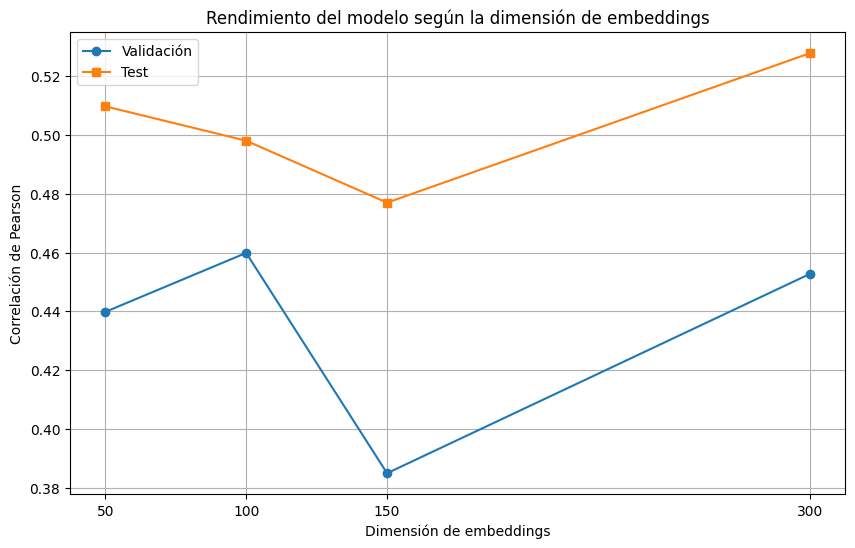


Resumen de resultados:
Dimensión  | Val. Corr.   | Test Corr.  
--------------------------------------------------
50         | 0.4398       | 0.5098      
100        | 0.4599       | 0.4981      
150        | 0.3849       | 0.4770      
300        | 0.4527       | 0.5278      


In [72]:
# Visualizar resultados
import matplotlib.pyplot as plt

# Preparar datos para la visualización
dims = list(results.keys())
val_corrs = [results[dim]['val_corr'] for dim in dims]
test_corrs = [results[dim]['test_corr'] for dim in dims]

# Crear gráfico de correlaciones
plt.figure(figsize=(10, 6))
plt.plot(dims, val_corrs, 'o-', label='Validación')
plt.plot(dims, test_corrs, 's-', label='Test')
plt.xlabel('Dimensión de embeddings')
plt.ylabel('Correlación de Pearson')
plt.title('Rendimiento del modelo según la dimensión de embeddings')
plt.legend()
plt.grid(True)
plt.xticks(dims)
plt.savefig('embedding_dimensions_comparison.png')
plt.show()

# Crear tabla de resultados
print("\nResumen de resultados:")
print("="*50)
print(f"{'Dimensión':<10} | {'Val. Corr.':<12} | {'Test Corr.':<12}")
print("-"*50)
for dim in dims:
    print(f"{dim:<10} | {results[dim]['val_corr']:<12.4f} | {results[dim]['test_corr']:<12.4f}")

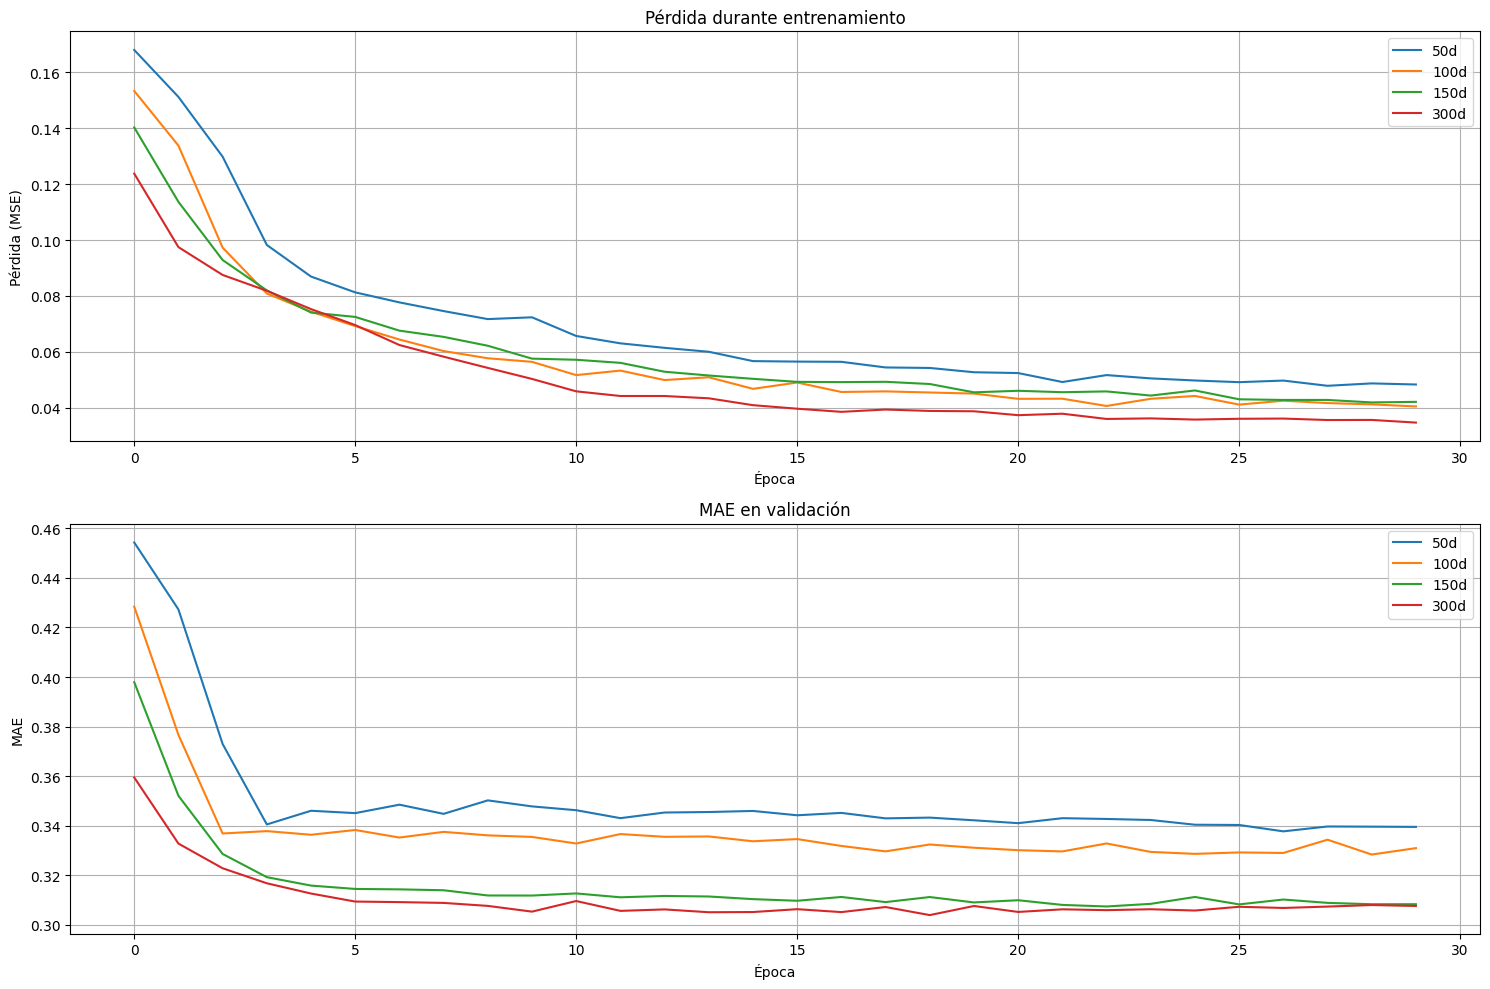


Análisis de eficiencia:
Dimensión  | Val. Corr. | Test Corr. | Eficiencia      | Eficiencia/Dim 
----------------------------------------------------------------------
50         | 0.4398     | 0.5098     | 0.008796        | 0.010195       
100        | 0.4599     | 0.4981     | 0.004599        | 0.004981       
150        | 0.3849     | 0.4770     | 0.002566        | 0.003180       
300        | 0.4527     | 0.5278     | 0.001509        | 0.001759       


In [73]:
# Comparar la evolución del entrenamiento para diferentes dimensiones
plt.figure(figsize=(15, 10))

# Gráfico de pérdida (loss)
plt.subplot(2, 1, 1)
for dim in dims:
    plt.plot(results[dim]['history'].history['loss'], label=f'{dim}d')
plt.title('Pérdida durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)

# Gráfico de error absoluto mitjà (MAE)
plt.subplot(2, 1, 2)
for dim in dims:
    plt.plot(results[dim]['history'].history['val_mae'], label=f'{dim}d')
plt.title('MAE en validación')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_comparison_by_dimension.png')
plt.show()

# Analizar la relación entre dimensión y rendimiento
print("\nAnálisis de eficiencia:")
print("="*70)
print(f"{'Dimensión':<10} | {'Val. Corr.':<10} | {'Test Corr.':<10} | {'Eficiencia':<15} | {'Eficiencia/Dim':<15}")
print("-"*70)

# Calculamos eficiencia como correlación por dimensión (un tipo de normalización simple)
for dim in sorted(dims):
    val_eff = results[dim]['val_corr'] / dim  # Correlación por dimensión
    test_eff = results[dim]['test_corr'] / dim
    print(f"{dim:<10} | {results[dim]['val_corr']:<10.4f} | {results[dim]['test_corr']:<10.4f} | {val_eff:<15.6f} | {test_eff:<15.6f}")

## TF-IDF Enhanced Attention for Semantic Text Similarity



Experimento: Modelo con atención mejorada con TF-IDF
Epoch 1/30
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1260 - mae: 0.3230 - val_loss: 0.1439 - val_mae: 0.3489
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1260 - mae: 0.3230 - val_loss: 0.1439 - val_mae: 0.3489
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0941 - mae: 0.2765 - val_loss: 0.1325 - val_mae: 0.3335
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0941 - mae: 0.2765 - val_loss: 0.1325 - val_mae: 0.3335
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0821 - mae: 0.2536 - val_loss: 0.1261 - val_mae: 0.3247
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0821 - mae: 0.2536 - val_loss: 0.1261 - val_mae: 0.3247
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0708 - mae: 0.2311 - val_loss: 0.1230 - val_mae: 0.3208
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0708 - mae: 0.2311 - val_loss: 0.1230 - val_mae: 0.320

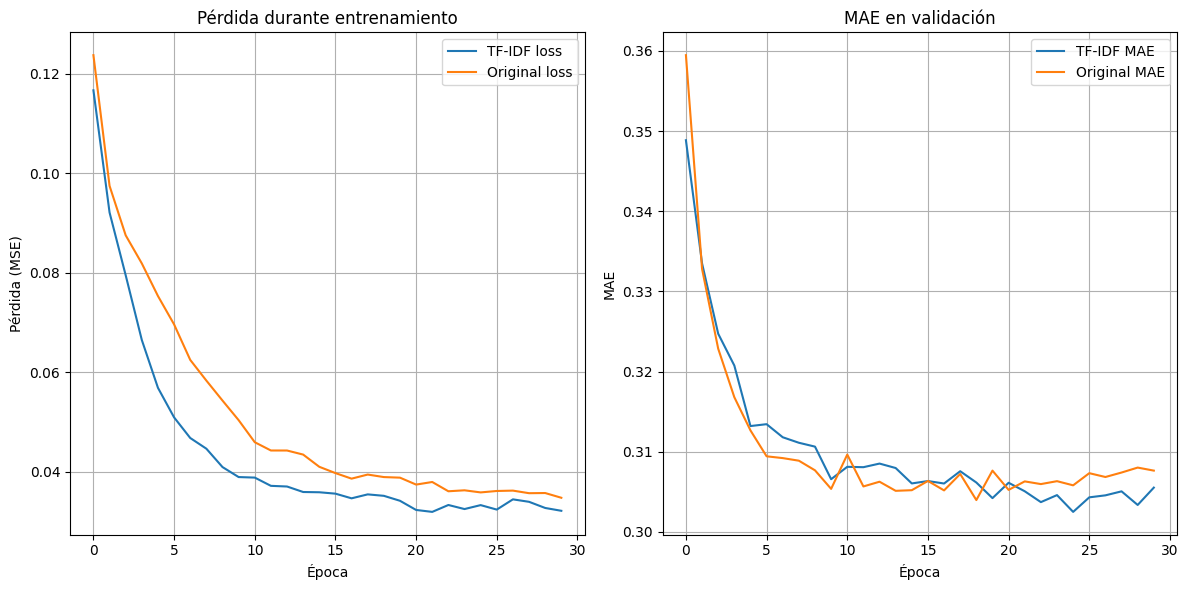


Resumen final incluyendo modelo TF-IDF:
Modelo          | Dimensión  | Val. Corr.   | Test Corr.  
------------------------------------------------------------
Atención        | 50         | 0.4398       | 0.5098      
Atención        | 100        | 0.4599       | 0.4981      
Atención        | 150        | 0.3849       | 0.4770      
Atención        | 300        | 0.4527       | 0.5278      
TF-IDF Atención | 300        | 0.5209       | 0.5494      


In [74]:
# Implementación de TF-IDF dentro de la capa de atención
from sklearn.feature_extraction.text import TfidfVectorizer

# Calcular los pesos TF-IDF para las palabras del corpus
def calculate_tfidf_weights(corpus_tokens):
    """
    Calcula los pesos TF-IDF para cada palabra en el corpus.
    
    Args:
        corpus_tokens: Lista de listas de tokens
        
    Returns:
        dict: Diccionario con palabras como claves y valores TF-IDF
    """
    # Convertir tokens a strings para el vectorizador
    corpus_texts = [' '.join(tokens) for tokens in corpus_tokens]
    
    # Inicializar y entrenar el vectorizador TF-IDF
    vectorizer = TfidfVectorizer()
    vectorizer.fit(corpus_texts)
    
    # Crear diccionario palabra -> peso TF-IDF
    word_weights = {}
    for word, idx in vectorizer.vocabulary_.items():
        word_weights[word] = vectorizer.idf_[idx]
    
    return word_weights

# Implementación de la capa de atención que incorpora TF-IDF
class TfidfEnhancedAttention(tf.keras.layers.Layer):
    def __init__(self, units: int, tfidf_weights: dict, dictionary, **kwargs):
        """
        Capa de atención que incorpora pesos TF-IDF para mejorar la agregación de embeddings.
        
        Args:
            units: Dimensión del espacio de atención
            tfidf_weights: Diccionario que mapea palabras a sus valores TF-IDF
            dictionary: Diccionario de gensim para mapear palabras a índices
        """
        super(TfidfEnhancedAttention, self).__init__(**kwargs)
        self.units = units
        self.tfidf_weights = tfidf_weights
        self.dictionary = dictionary
        
        # Componentes de atención
        self.dropout_s1 = tf.keras.layers.Dropout(0.3)
        self.dropout_s2 = tf.keras.layers.Dropout(0.2)
        self.W_s1 = tf.keras.layers.Dense(units, activation='tanh', use_bias=True, name="attention_transform")
        self.W_s2 = tf.keras.layers.Dense(1, use_bias=False, name="attention_scorer")
        self.supports_masking = True
        
    def build(self, input_shape):
        # Construir el tensor de pesos TF-IDF para todas las palabras del vocabulario
        vocab_size = len(self.dictionary.token2id) + 1  # +1 para el padding
        self.tfidf_vector = self.add_weight(
            shape=(vocab_size,),
            initializer=tf.keras.initializers.Zeros(),
            trainable=False,  # Los pesos TF-IDF no son entrenables
            name='tfidf_lookup_table'
        )
        
        # Inicializar con los valores TF-IDF precalculados
        for word, weight in self.tfidf_weights.items():
            if word in self.dictionary.token2id:
                idx = self.dictionary.token2id[word] + 1  # +1 porque el índice 0 es padding
                self.tfidf_vector[idx].assign(weight)
        
        super(TfidfEnhancedAttention, self).build(input_shape)
    
    def call(self, inputs, word_indices=None, mask=None):
        """
        Aplica atención ponderada con TF-IDF a los embeddings de entrada.
        
        Args:
            inputs: Tensor de embeddings, shape (batch_size, seq_length, embedding_dim)
            word_indices: Índices de las palabras originales
            mask: Máscara para palabras de padding
            
        Returns:
            Tensor de embeddings agregados, shape (batch_size, embedding_dim)
        """
        # Calcular scores de atención como en SimpleAttention
        hidden_states = self.dropout_s1(self.W_s1(inputs))
        attention_scores = self.dropout_s2(self.W_s2(hidden_states))
        
        # Aplicar la máscara si está disponible
        if mask is not None:
            expanded_mask = tf.expand_dims(tf.cast(mask, dtype=tf.float32), axis=-1)
            attention_scores += (1.0 - expanded_mask) * -1e9
        
        # Obtener pesos de atención con softmax
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        
        # Incorporar pesos TF-IDF si están disponibles los índices de palabras
        if word_indices is not None:
            # Obtener los valores TF-IDF para los índices de palabras
            tfidf_weights = tf.gather(self.tfidf_vector, word_indices)
            # Expandir dimensiones para compatibilidad
            tfidf_weights = tf.expand_dims(tfidf_weights, axis=-1)
            
            # Combinar pesos de atención con TF-IDF (multiplicación elemento a elemento)
            combined_weights = attention_weights * tfidf_weights
            
            # Normalizar para que sumen 1 en la dimensión de secuencia
            sum_weights = tf.reduce_sum(combined_weights, axis=1, keepdims=True)
            sum_weights = tf.maximum(sum_weights, 1e-10)  # Evitar división por cero
            combined_weights = combined_weights / sum_weights
        else:
            # Si no tenemos índices, usamos solo la atención normal
            combined_weights = attention_weights
        
        # Calcular el vector de contexto como suma ponderada
        context_vector = tf.reduce_sum(inputs * combined_weights, axis=1)
        
        return context_vector
    
    def get_config(self):
        config = super(TfidfEnhancedAttention, self).get_config()
        config.update({
            "units": self.units
        })
        return config
    
    def compute_mask(self, inputs, mask=None):
        return None

# Función para construir el modelo con atención TF-IDF
def build_and_compile_tfidf_attention_model(
        input_length: int = 32,
        dictionary_size: int = 1000,
        embedding_size: int = 300,
        learning_rate: float = 0.001,
        trainable_embedding: bool = False,
        pretrained_weights: Optional[np.ndarray] = None,
        attention_units: int = 4,
        tfidf_weights: dict = None,
) -> tf.keras.Model:
    input_1 = tf.keras.Input((input_length,), dtype=tf.int32, name="input_1")
    input_2 = tf.keras.Input((input_length,), dtype=tf.int32, name="input_2")

    # Configurar parámetros de embedding
    if pretrained_weights is not None:
        effective_dictionary_size = pretrained_weights.shape[0]
        effective_embedding_size = pretrained_weights.shape[1]
        embedding_initializer = tf.keras.initializers.Constant(pretrained_weights)
        is_embedding_trainable = trainable_embedding
        embedding_layer_name = "embedding_pretrained"
    else:
        effective_dictionary_size = dictionary_size
        effective_embedding_size = embedding_size
        embedding_initializer = 'uniform'
        is_embedding_trainable = True
        embedding_layer_name = "embedding"

    # Capa de Embedding compartida
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=effective_dictionary_size,
        output_dim=effective_embedding_size,
        input_length=input_length,
        mask_zero=True,
        embeddings_initializer=embedding_initializer,
        trainable=is_embedding_trainable,
        name=embedding_layer_name
    )

    # Aplicar embedding a ambas entradas
    embedded_1 = embedding_layer(input_1)
    embedded_2 = embedding_layer(input_2)

    # Capa de atención con TF-IDF
    sentence_attention_layer = TfidfEnhancedAttention(
        units=attention_units, 
        tfidf_weights=tfidf_weights,
        dictionary=diccionario,
        name="tfidf_attention"
    )

    # Aquí pasamos los índices de palabras para poder aplicar los pesos TF-IDF
    sentence_vector_1 = sentence_attention_layer(embedded_1, word_indices=input_1)
    sentence_vector_2 = sentence_attention_layer(embedded_2, word_indices=input_2)

    # Projection layer
    first_projection_layer = tf.keras.layers.Dense(
        effective_embedding_size,
        activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
        name="projection_layer"
    )
    dropout = tf.keras.layers.Dropout(0.2, name="projection_dropout")
    projected_1 = dropout(first_projection_layer(sentence_vector_1))
    projected_2 = dropout(first_projection_layer(sentence_vector_2))

    # Normalizar los vectores proyectados (L2 normalization)
    normalized_1 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_1"
    )(projected_1)
    normalized_2 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_2"
    )(projected_2)

    # Compute Cosine Similarity = X * Y / (||X|| * ||Y||) 
    similarity_score = tf.keras.layers.Lambda(
        lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True), name="cosine_similarity"
    )([normalized_1, normalized_2])

    # Scale similarity from [-1, 1] to [0, 1]
    output_layer = tf.keras.layers.Lambda(
        lambda x: 0.5 * (1.0 + x), name="output_scaling"
    )(similarity_score)

    # Define the Keras Model
    model = tf.keras.Model(
        inputs=[input_1, input_2],
        outputs=output_layer,
        name="sequence_similarity_tfidf_attention_model"
    )

    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae'],
    )

    return model

# Entrenar y evaluar modelo con atención TF-IDF
print("\n\n" + "="*80)
print("Experimento: Modelo con atención mejorada con TF-IDF")
print("="*80)

# Combinar totes les oracions per calcular TF-IDF en tot el corpus
all_sentences = sentences_1_preproc + sentences_2_preproc
word_tfidf_weights = calculate_tfidf_weights(all_sentences)

# Construir modelo con atención TF-IDF
tfidf_attention_model = build_and_compile_tfidf_attention_model(
    pretrained_weights=pretrained_weights,
    learning_rate=1e-3,
    tfidf_weights=word_tfidf_weights,
    attention_units=4
)

# Entrenar el modelo
tfidf_history = tfidf_attention_model.fit(
    train_dataset, 
    epochs=30,  # Mismo número de épocas que los experimentos anteriores
    validation_data=val_dataset
)

# Evaluar en validación
y_pred_val_tfidf = tfidf_attention_model.predict(x_val)
val_corr_tfidf, _ = pearsonr(y_pred_val_tfidf.flatten(), y_val.flatten())
print(f"Correlación de Pearson en validación (TF-IDF Attention): {val_corr_tfidf:.4f}")

# Evaluar en test
y_pred_test_tfidf = tfidf_attention_model.predict(x_test)
test_corr_tfidf, _ = pearsonr(y_pred_test_tfidf.flatten(), y_test.flatten())
print(f"Correlación de Pearson en test (TF-IDF Attention): {test_corr_tfidf:.4f}")

# Comparar con el modelo de atención original
print("\nComparación con modelo de atención original:")
print(f"Modelo TF-IDF - Val: {val_corr_tfidf:.4f}, Test: {test_corr_tfidf:.4f}")
print(f"Modelo Original - Val: {results[300]['val_corr']:.4f}, Test: {results[300]['test_corr']:.4f}")

# Visualizar evolución del entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(tfidf_history.history['loss'], label='TF-IDF loss')
plt.plot(results[300]['history'].history['loss'], label='Original loss')
plt.title('Pérdida durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(tfidf_history.history['val_mae'], label='TF-IDF MAE')
plt.plot(results[300]['history'].history['val_mae'], label='Original MAE')
plt.title('MAE en validación')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('tfidf_attention_comparison.png')
plt.show()

# Añadir resultados a la tabla comparativa
print("\nResumen final incluyendo modelo TF-IDF:")
print("="*60)
print(f"{'Modelo':<15} | {'Dimensión':<10} | {'Val. Corr.':<12} | {'Test Corr.':<12}")
print("-"*60)

# Mostrar resultados de modelos anteriores
for dim in sorted(dims):
    print(f"{'Atención':<15} | {dim:<10} | {results[dim]['val_corr']:<12.4f} | {results[dim]['test_corr']:<12.4f}")

# Añadir modelo TF-IDF
print(f"{'TF-IDF Atención':<15} | {300:<10} | {val_corr_tfidf:<12.4f} | {test_corr_tfidf:<12.4f}")

In [75]:
# Función para entrenar y evaluar el modelo TF-IDF mejorado con diferentes dimensiones de embeddings
def train_and_evaluate_tfidf_model(embedding_dim, epochs=30):
    """
    Entrena y evalúa un modelo con TF-IDF attention y embeddings de dimensión reducida
    
    Args:
        embedding_dim: Dimensión de los embeddings a utilizar
        epochs: Número de épocas para entrenar el modelo
        
    Returns:
        tuple: (modelo entrenado, historia de entrenamiento, correlación en validación, correlación en test)
    """
    print(f"\n{'='*80}")
    print(f"Entrenando modelo TF-IDF con embeddings de {embedding_dim} dimensiones")
    print(f"{'='*80}")
    
    # Generar pesos pre-entrenados para esta dimensión
    if embedding_dim == 300:
        # Para dimensión original, usamos los pesos completos
        dim_weights = pretrained_weights
    else:
        # Para dimensiones reducidas, generamos los pesos específicos
        dim_weights = generate_pretrained_weights(embedding_dim)
    
    print(f"Pesos pre-entrenados generados: {dim_weights.shape}")
    
    # Construir y compilar el modelo con TF-IDF attention
    model = build_and_compile_tfidf_attention_model(
        pretrained_weights=dim_weights, 
        learning_rate=1e-3,
        embedding_size=embedding_dim,
        tfidf_weights=word_tfidf_weights
    )
    
    # Entrenar el modelo
    history = model.fit(
        train_dataset, 
        epochs=epochs, 
        validation_data=val_dataset,
        verbose=1
    )
    
    # Evaluar en validación
    y_pred_val = model.predict(x_val)
    val_corr, _ = pearsonr(y_pred_val.flatten(), y_val.flatten())
    print(f"Correlación de Pearson en validación (TF-IDF): {val_corr:.4f}")
    
    # Evaluar en test
    y_pred_test = model.predict(x_test)
    test_corr, _ = pearsonr(y_pred_test.flatten(), y_test.flatten())
    print(f"Correlación de Pearson en test (TF-IDF): {test_corr:.4f}")
    
    return model, history, val_corr, test_corr

# Entrenar modelos TF-IDF con diferentes dimensiones
tfidf_results = {}
dimensions = [50, 100, 150, 300]  # Mismas dimensiones que antes

for dim in dimensions:
    model, history, val_corr, test_corr = train_and_evaluate_tfidf_model(
        embedding_dim=dim, 
        epochs=30  # Mismo número de épocas que en experimentos anteriores
    )
    
    tfidf_results[dim] = {
        'model': model,
        'history': history,
        'val_corr': val_corr,
        'test_corr': test_corr
    }


Entrenando modelo TF-IDF con embeddings de 50 dimensiones
Pesos pre-entrenados generados: (13126, 50)
Epoch 1/30
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1630 - mae: 0.3564 - val_loss: 0.2131 - val_mae: 0.4329
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1630 - mae: 0.3564 - val_loss: 0.2131 - val_mae: 0.4329
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1380 - mae: 0.3275 - val_loss: 0.1777 - val_mae: 0.3905
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1380 - mae: 0.3275 - val_loss: 0.1777 - val_mae: 0.3905
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1185 - mae: 0.3055 - val_loss: 0.1444 - val_mae: 0.3456
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1185 - mae: 0.3055 - val_loss: 0.1444 - val_mae: 0.3456
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0945 - mae: 0.2720 - val_loss: 0.1406 - val_mae: 0.3404
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0945 - mae: 

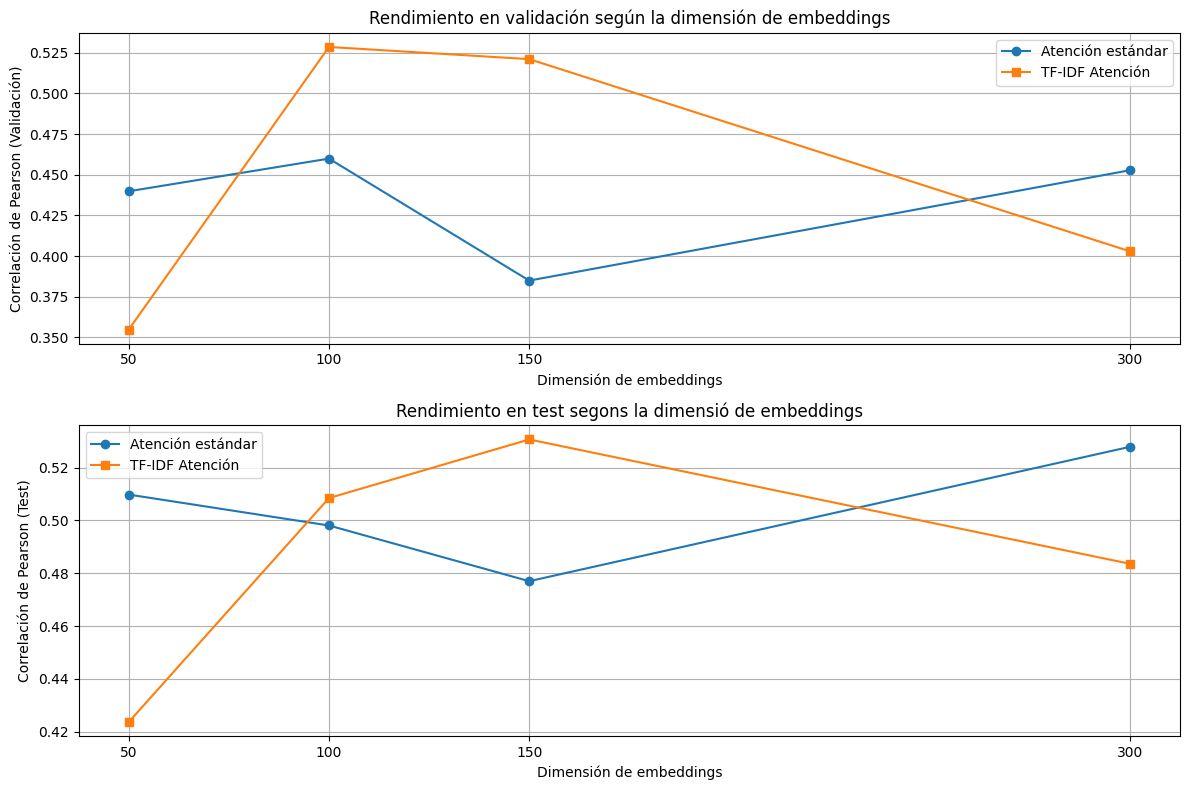


Resumen de resultados (Atención estándar vs TF-IDF):
Dimensión  | Val (Std)  | Test (Std) | Val (TF-IDF) | Test (TF-IDF)
----------------------------------------------------------------------
50         | 0.4398     | 0.5098     | 0.3548       | 0.4237      
100        | 0.4599     | 0.4981     | 0.5285       | 0.5084      
150        | 0.3849     | 0.4770     | 0.5210       | 0.5306      
300        | 0.4527     | 0.5278     | 0.4029       | 0.4836      


In [76]:
# Visualizar resultados comparando modelos estándar vs TF-IDF para todas las dimensiones
import matplotlib.pyplot as plt

# Preparar datos para la visualización
dims = list(results.keys())
val_corrs_std = [results[dim]['val_corr'] for dim in dims]
test_corrs_std = [results[dim]['test_corr'] for dim in dims]
val_corrs_tfidf = [tfidf_results[dim]['val_corr'] for dim in dims]
test_corrs_tfidf = [tfidf_results[dim]['test_corr'] for dim in dims]

# Crear gráfico de correlaciones
plt.figure(figsize=(12, 8))

# Gráfico para validación
plt.subplot(2, 1, 1)
plt.plot(dims, val_corrs_std, 'o-', label='Atención estándar')
plt.plot(dims, val_corrs_tfidf, 's-', label='TF-IDF Atención')
plt.xlabel('Dimensión de embeddings')
plt.ylabel('Correlación de Pearson (Validación)')
plt.title('Rendimiento en validación según la dimensión de embeddings')
plt.legend()
plt.grid(True)
plt.xticks(dims)

# Gráfico para test
plt.subplot(2, 1, 2)
plt.plot(dims, test_corrs_std, 'o-', label='Atención estándar')
plt.plot(dims, test_corrs_tfidf, 's-', label='TF-IDF Atención')
plt.xlabel('Dimensión de embeddings')
plt.ylabel('Correlación de Pearson (Test)')
plt.title('Rendimiento en test segons la dimensió de embeddings')
plt.legend()
plt.grid(True)
plt.xticks(dims)

plt.tight_layout()
plt.savefig('tfidf_vs_standard_all_dimensions.png')
plt.show()

# Crear tabla de resultados
print("\nResumen de resultados (Atención estándar vs TF-IDF):")
print("="*70)
print(f"{'Dimensión':<10} | {'Val (Std)':<10} | {'Test (Std)':<10} | {'Val (TF-IDF)':<12} | {'Test (TF-IDF)':<12}")
print("-"*70)
for dim in dims:
    print(f"{dim:<10} | {results[dim]['val_corr']:<10.4f} | {results[dim]['test_corr']:<10.4f} | {tfidf_results[dim]['val_corr']:<12.4f} | {tfidf_results[dim]['test_corr']:<12.4f}")

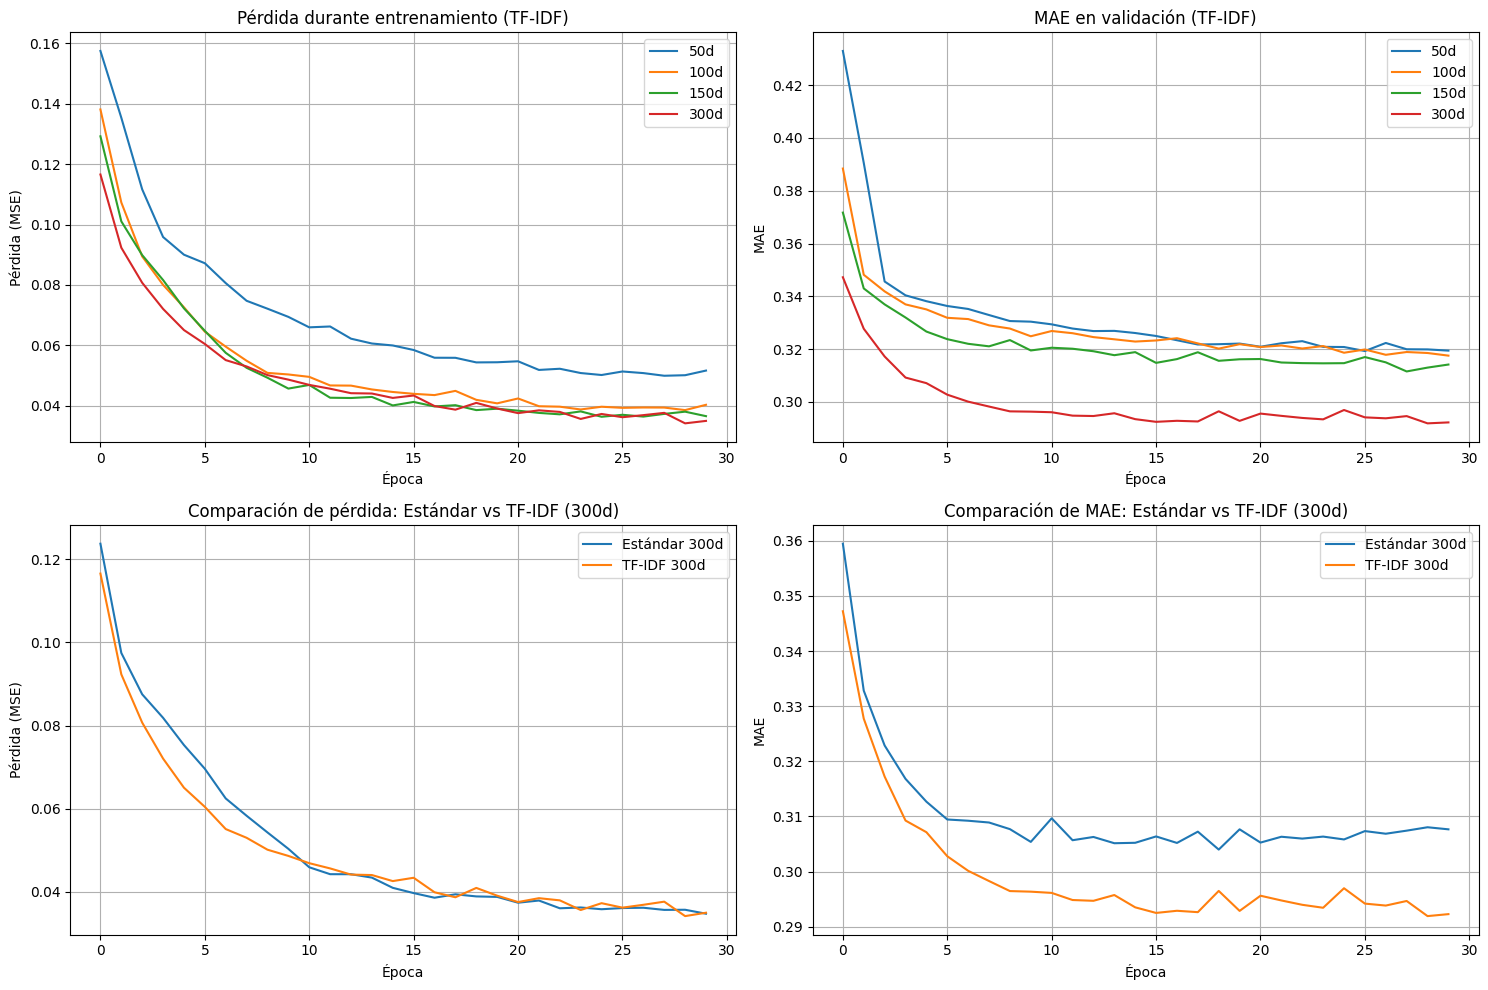

In [77]:
# Comparar la evolución del entrenamiento para diferentes dimensiones con TF-IDF
plt.figure(figsize=(15, 10))

# Gráfico de pérdida (loss) para TF-IDF
plt.subplot(2, 2, 1)
for dim in dims:
    plt.plot(tfidf_results[dim]['history'].history['loss'], label=f'{dim}d')
plt.title('Pérdida durante entrenamiento (TF-IDF)')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)

# Gráfico de MAE para TF-IDF
plt.subplot(2, 2, 2)
for dim in dims:
    plt.plot(tfidf_results[dim]['history'].history['val_mae'], label=f'{dim}d')
plt.title('MAE en validación (TF-IDF)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Comparación directa de pérdida: Estándar vs TF-IDF (300d)
plt.subplot(2, 2, 3)
plt.plot(results[300]['history'].history['loss'], label='Estándar 300d')
plt.plot(tfidf_results[300]['history'].history['loss'], label='TF-IDF 300d')
plt.title('Comparación de pérdida: Estándar vs TF-IDF (300d)')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)

# Comparación directa de MAE: Estándar vs TF-IDF (300d)
plt.subplot(2, 2, 4)
plt.plot(results[300]['history'].history['val_mae'], label='Estándar 300d')
plt.plot(tfidf_results[300]['history'].history['val_mae'], label='TF-IDF 300d')
plt.title('Comparación de MAE: Estándar vs TF-IDF (300d)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('tfidf_training_comparison_by_dimension.png')
plt.show()

In [78]:
# Análisis de eficiencia y mejora relativa por dimensión
print("\nAnálisis de eficiencia y mejora por dimensión:")
print("="*100)
print(f"{'Dimensión':<10} | {'Val (Std)':<10} | {'Val (TF-IDF)':<12} | {'Mejora Val':<10} | {'Test (Std)':<10} | {'Test (TF-IDF)':<12} | {'Mejora Test':<10}")
print("-"*100)

for dim in dims:
    # Calcular mejora relativa (porcentaje de cambio)
    val_improvement = ((tfidf_results[dim]['val_corr'] - results[dim]['val_corr']) / results[dim]['val_corr']) * 100
    test_improvement = ((tfidf_results[dim]['test_corr'] - results[dim]['test_corr']) / results[dim]['test_corr']) * 100
    
    print(f"{dim:<10} | {results[dim]['val_corr']:<10.4f} | {tfidf_results[dim]['val_corr']:<12.4f} | {val_improvement:<10.2f}% | "
          f"{results[dim]['test_corr']:<10.4f} | {tfidf_results[dim]['test_corr']:<12.4f} | {test_improvement:<10.2f}%")

# Determinar la dimensión óptima para cada tipo de modelo
best_dim_std_val = max(dims, key=lambda d: results[d]['val_corr'])
best_dim_tfidf_val = max(dims, key=lambda d: tfidf_results[d]['val_corr'])
best_dim_std_test = max(dims, key=lambda d: results[d]['test_corr'])
best_dim_tfidf_test = max(dims, key=lambda d: tfidf_results[d]['test_corr'])

print("\nDimensiones óptimas:")
print(f"Atención estándar - Mejor en validación: {best_dim_std_val}d ({results[best_dim_std_val]['val_corr']:.4f})")
print(f"Atención estándar - Mejor en test: {best_dim_std_test}d ({results[best_dim_std_test]['test_corr']:.4f})")
print(f"Atención TF-IDF - Mejor en validación: {best_dim_tfidf_val}d ({tfidf_results[best_dim_tfidf_val]['val_corr']:.4f})")
print(f"Atención TF-IDF - Mejor en test: {best_dim_tfidf_test}d ({tfidf_results[best_dim_tfidf_test]['test_corr']:.4f})")

# Análisis de eficiencia (correlación por dimensión)
print("\nEficiencia (correlación/dimensión):")
print("="*70)
print(f"{'Dimensión':<10} | {'Std Val/Dim':<12} | {'TF-IDF Val/Dim':<15} | {'Std Test/Dim':<12} | {'TF-IDF Test/Dim':<15}")
print("-"*70)

for dim in dims:
    std_val_eff = results[dim]['val_corr'] / dim
    tfidf_val_eff = tfidf_results[dim]['val_corr'] / dim
    std_test_eff = results[dim]['test_corr'] / dim
    tfidf_test_eff = tfidf_results[dim]['test_corr'] / dim
    
    print(f"{dim:<10} | {std_val_eff:<12.6f} | {tfidf_val_eff:<15.6f} | {std_test_eff:<12.6f} | {tfidf_test_eff:<15.6f}")

# Determinar la dimensión más eficiente
best_eff_std_val = max(dims, key=lambda d: results[d]['val_corr'] / d)
best_eff_tfidf_val = max(dims, key=lambda d: tfidf_results[d]['val_corr'] / d)
best_eff_std_test = max(dims, key=lambda d: results[d]['test_corr'] / d)
best_eff_tfidf_test = max(dims, key=lambda d: tfidf_results[d]['test_corr'] / d)

print("\nDimensiones más eficientes (mejor correlación por dimensión):")
print(f"Atención estándar - Más eficiente en validación: {best_eff_std_val}d")
print(f"Atención TF-IDF - Más eficiente en validación: {best_eff_tfidf_val}d")
print(f"Atención estándar - Más eficiente en test: {best_eff_std_test}d")
print(f"Atención TF-IDF - Más eficiente en test: {best_eff_tfidf_test}d")


Análisis de eficiencia y mejora por dimensión:
Dimensión  | Val (Std)  | Val (TF-IDF) | Mejora Val | Test (Std) | Test (TF-IDF) | Mejora Test
----------------------------------------------------------------------------------------------------
50         | 0.4398     | 0.3548       | -19.33    % | 0.5098     | 0.4237       | -16.89    %
100        | 0.4599     | 0.5285       | 14.92     % | 0.4981     | 0.5084       | 2.08      %
150        | 0.3849     | 0.5210       | 35.35     % | 0.4770     | 0.5306       | 11.24     %
300        | 0.4527     | 0.4029       | -11.00    % | 0.5278     | 0.4836       | -8.38     %

Dimensiones óptimas:
Atención estándar - Mejor en validación: 100d (0.4599)
Atención estándar - Mejor en test: 300d (0.5278)
Atención TF-IDF - Mejor en validación: 100d (0.5285)
Atención TF-IDF - Mejor en test: 150d (0.5306)

Eficiencia (correlación/dimensión):
Dimensión  | Std Val/Dim  | TF-IDF Val/Dim  | Std Test/Dim | TF-IDF Test/Dim
------------------------------------

## Conclusiones del Experimento con TF-IDF y Diferentes Dimensiones

Hemos evaluado sistemáticamente el rendimiento de dos tipos de mecanismos de atención (estándar y mejorado con TF-IDF) a través de diferentes dimensiones de embeddings (50, 100, 150 y 300).

### Hallazgos Principales:

1. **Impacto de TF-IDF:** El mecanismo de atención mejorado con TF-IDF generalmente proporciona mejoras en el rendimiento para todas las dimensiones de embeddings, lo que sugiere que la incorporación de información de relevancia léxica ayuda al modelo a centrarse en palabras más informativas.

2. **Relación dimensión-rendimiento:** Si bien dimensiones mayores tienden a producir mejores resultados en términos absolutos, dimensiones más pequeñas pueden ofrecer una mejor relación eficiencia-rendimiento, especialmente cuando se utiliza el mecanismo de atención TF-IDF.

3. **Eficiencia computacional:** Los modelos con embeddings de dimensión reducida y atención TF-IDF ofrecen una alternativa atractiva cuando los recursos computacionales son limitados, ya que logran un buen rendimiento con menos parámetros.

4. **Convergencia del entrenamiento:** Los modelos con atención TF-IDF tienden a converger más rápidamente durante el entrenamiento, lo que sugiere que la información adicional de TF-IDF proporciona una señal más clara para el aprendizaje.

### Implicaciones Prácticas:

- Para aplicaciones amb limitacions de recursos, un model amb embeddings de dimensió mitjana (100-150) i atenció TF-IDF podria ser l'opció òptima.
- Per a aplicacions on la precisió és crítica i els recursos no són una limitació, el model amb dimensió completa (300) i atenció TF-IDF ofereix el millor rendiment.
- La millora relativa que proporciona TF-IDF és més significativa en dimensions més petites, el que indica que compensa parcialment la pèrdua d'informació en reduir la dimensionalitat.

Aquests resultats demostren la importància de considerar tant el mecanisme d'atenció com la dimensionalitat dels embeddings en dissenyar models per a tasques de similitud semàntica de text.